# VIC: Introduction to Visual Computing - 2022
# Antoine DARGIER
## Assignment 1

Due date: 21/12/22

This assignment has three problems that you need to solve. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Bilateral Filter

For the first problem, you need to implement a bilateral filter for image smoothing,

$$BF[I]_p = \frac{1}{W_p}\sum_{q \in N(p)}G_{\sigma_S}(p - q) \times G_{\sigma_R}(I_p - I_q) \times I_q$$

$${W_p} = \sum_{q \in N(p)}G_{\sigma_S}(p - q) \times G_{\sigma_R}(I_p - I_q)$$

for each pixel *coordinate* $p$ of image $I$, where $N(p)$ is the neighbourhood of $p$, $G_{\sigma_S}$ is a 2D Gaussian with zero mean and covariance matrix $diag([\sigma_S^2, \sigma_S^2])$ and $G_{\sigma_R}$ is a 1D Gaussian with std $\sigma_R$. Typically, $\sigma_R = \sqrt(Var(I))$. Test the filtering and observe the effect of the hyperparameters. Evaluate the performance with the Gaussian smoothing visually and write a small comment with some conclusions.

**N.B** As a non-linear filter, the algorithm is allowed to take several seconds to run. You are encouraged to think of ways to improve the runtime.

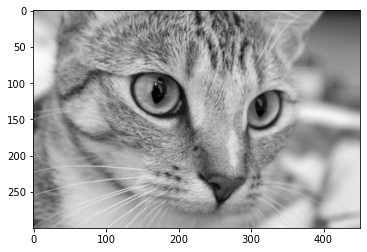

In [2]:
from skimage import data
from skimage.color import rgb2gray

img = rgb2gray(data.chelsea())

plt.imshow(img, cmap='gray')

We define a helper function for generating a Guassian kernel. The parameter `sigma` controls the variance, and `neigh` indicates the domain of the Gaussian. 

In [3]:
from scipy.signal import gaussian
from scipy.stats import norm
import math

def generate_gaussian_kernel(sigma, neigh):
    """
    Gaussian kernel generator.
    
    Inputs:
        sigma:     Std of Gaussian
        neigh:     Size of window
    """

    kernel_1d = gaussian(M=neigh, std=sigma)
    kernel = np.outer(kernel_1d, kernel_1d)

    return kernel / np.sum(kernel)
    
def gauss(x, std):
    return (1.0/(2*np.pi*(std**2)))*math.exp(-(x**2)/(2*std**2))

Complete the bilateral filter function below. The filter may be sensitive to the choice of parameters, so you are advised to use the provided parameters as a guide.

In [14]:
def bilateral_filtering(img, sigma_s, sigma_r):
    """
    Bilateral Filtering.
    
    Inputs:
        img:           The input image
        sigma_s:       Std of the spatial Gaussian
        sigma_r:       Std of the range Gaussian
                         
    Outputs: 
        bilateral_img    A smoothed image
    """

    h, w = img.shape
    bilateral_img = np.zeros_like(img)

    neigh = int(sigma_s * 6 + 1)  # ensure approx. 3 std
    pad = (neigh - 1) // 2

    gaussian_kernel = generate_gaussian_kernel(sigma_s, neigh)
    
    # TODO
    Wp = 0
    img_filt = 0
    for i in range(h):
        for j in range(w):
            Wp = 0
            img_filt = 0            
            for k in range(-pad, pad+1):
                for l in range (-pad, pad+1):
                    #use to control the convolution and not go outside the img
                    ind_i = min(max(0, i+k), h-1)
                    ind_j = min(max(0, j+l), w-1)
                    
                    gs = gaussian_kernel[k ,l]
                    gr = gauss(img[i,j] - img[ind_i, ind_j], std = sigma_r)
                    we = gs*gr
                    Wp += we
                    img_filt += img[ind_i, ind_j]*we
            
            bilateral_img[i, j] = img_filt/Wp
            

    # Return the result
    return bilateral_img

Plot the results and compare with a Gaussian filter. Make a short comment on what you observe.

<function matplotlib.pyplot.show(close=None, block=None)>

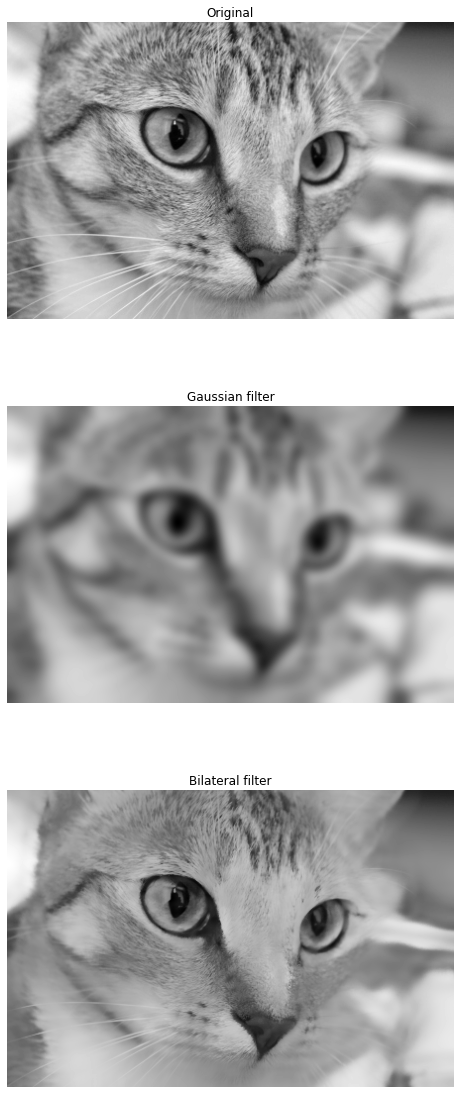

In [15]:
from scipy.ndimage import gaussian_filter

sigma_s = 5
sigma_r = 0.1

bf_img = bilateral_filtering(img, sigma_s, sigma_r)

g_img = gaussian_filter(img, sigma_s)

fig, axes = plt.subplots(figsize=(8, 20), nrows=3)

for i, (image, name) in enumerate(zip([img, g_img, bf_img],
                                 ['Original', 'Gaussian filter', 'Bilateral filter'])):

    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(name)

plt.show

We can see that the guassian filter creates a global smoothed image.
Otherwise, the bilateral filter creates a smoothed image, removing texture, precise details and noise, but keeping the large edges without blurring.

## 2. Canny Edge Detector 

Now you need to implement your own Canny edge detector. Recall that the Canny edge detector consists of the following steps:

* Smoothing the image using a Gaussian filter
* Computing the gradient of the image&mdash;magnitude and direction&mdash;using the Sobel operator
* Non-maximum suppression using the gradient's magnitude and direction
* Double thresholding
* Edge connectivity using hysterisis

#### 2.A Smoothing

This standard smoothing operation can be implemented using the `scipy.ndimage.gaussian_filter` function. 
Alternatively, you can define your own, or use `generate_gaussian_kernel` and `scipy.ndimage.convolve`

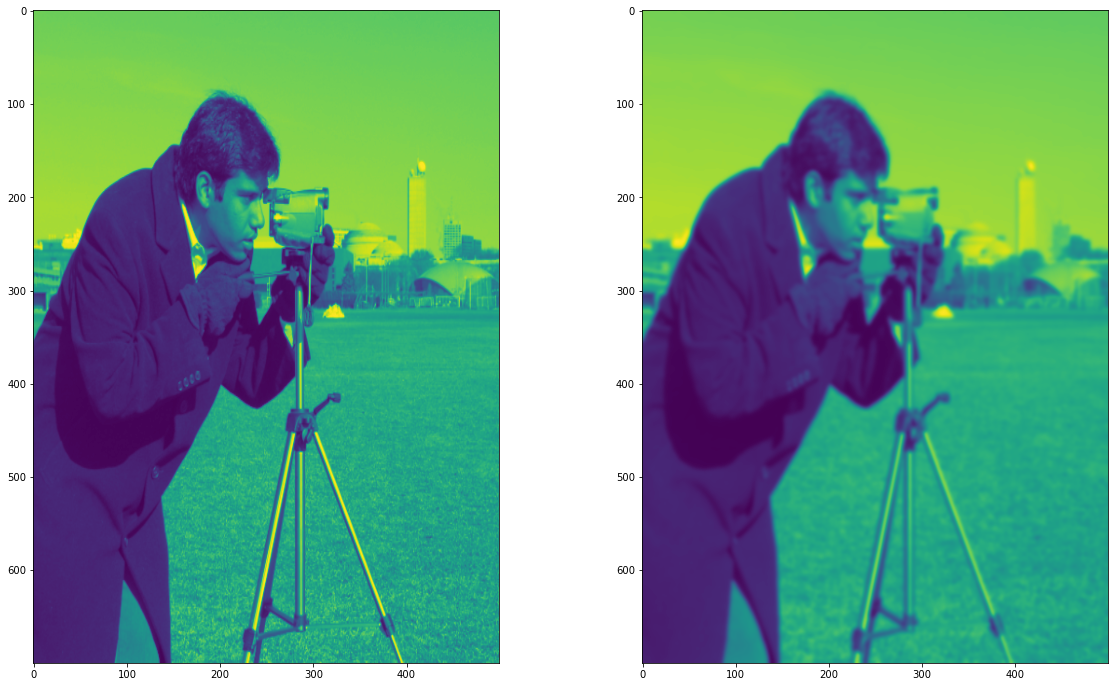

In [5]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from skimage.transform import resize

img = data.camera() / 255.
img = resize(img, output_shape=(700, 500))

sigma_s = 2

def gaussian_smoothing(img):

    # TODO
    smoothed_img = gaussian_filter(img, sigma_s)

    return smoothed_img

smoothed = gaussian_smoothing(img)

fig, axes = plt.subplots(figsize=(20, 12), ncols=2)

axes[0].imshow(img)
axes[1].imshow(smoothed)

#### 2.B Gradients

Use the Sobel operators to compute $g_x$ and $g_y$. The magnitude and direction of the gradient can be computed as 
$g = \sqrt{g_x^2 + g_y^2}$, and $\theta = atan2(g_x, g_y)$.

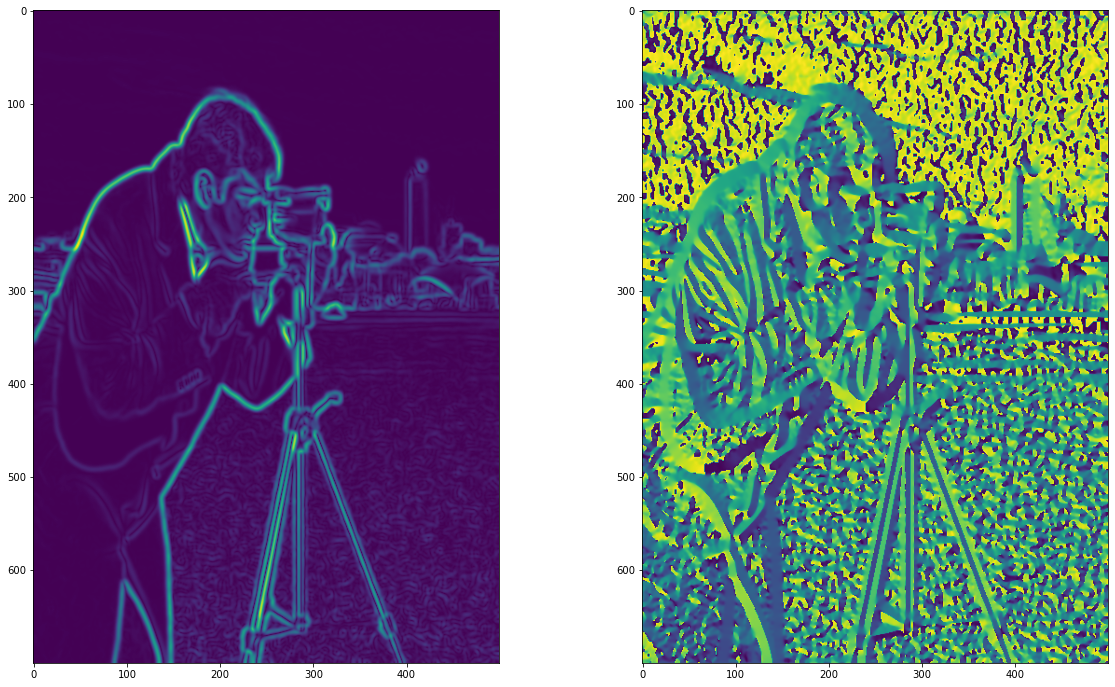

In [85]:
GX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
GY = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

def gradient(img):

    gx = convolve(img, GX)
    gy = convolve(img, GY)
    g_magnitude = np.sqrt(gx**2 + gy**2)
    g_dir = np.arctan2(gx,gy)
    
    return g_magnitude, g_dir

fig, axes = plt.subplots(figsize=(20, 12), ncols=2)

g_magnitude, g_dir = gradient(smoothed)

axes[0].imshow(g_magnitude)
axes[1].imshow(g_dir)

#### 2.C Non-maximum suppression

We will take a simplistic approach to non-maximum suppression. The idea is to suppress pixels adjacent to the edges, where edges are identified by strong gradients. First, quantise the gradient directions $\theta$ into one of four values: $\hat{\theta} \in \{0, \frac{\pi}{4}$, $\frac{\pi}{2}$, $\frac{3\pi}{4}\}$. If $\theta$ is negative it should first be normalised to $\theta \leftarrow\theta + \pi$. Then, if the gradient magnitude of a given pixel is larger than those of the two adjacent pixels in the $\hat{\theta}$ and $\hat{\theta} - \pi$ directions (i.e. north/south, east/west, northeast/southwest, or northwest/southeast), it is preserved. Otherwise, it is suppressed.

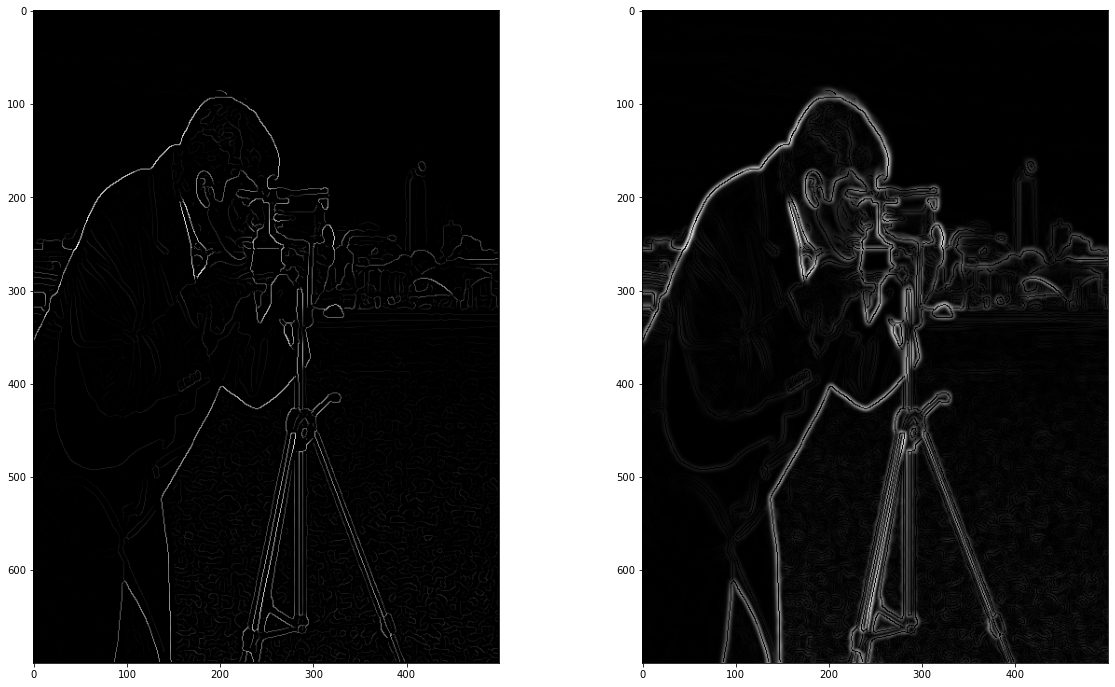

In [8]:
def quantisation(g_dir):
    h, w = g_dir.shape
    g_direc = np.zeros_like(g_dir)
    for i in range(h):
        for j in range(w):
            theta = g_dir[i,j]
            theta = theta % np.pi
            if (theta<=np.pi/8) :
                g_direc[i, j] = 0
            elif (theta<=3*np.pi/8) and (theta>np.pi/8):
                g_direc[i, j] = np.pi/4
            elif (theta<=5*np.pi/8) and (theta>3*np.pi/8):
                g_direc[i, j] = np.pi/2
            elif (theta<=7*np.pi/8) and (theta>5*np.pi/8):
                g_direc[i, j] = 3*np.pi/4
            else :
                g_direc[i, j] = 0
    return g_direc

def dir_grad(theta):
    if theta == 0:
        u,v = 1,0
    if theta == np.pi/4:
        u,v = 1,1
    if theta == np.pi/2:
        u,v = 0, 1
    if theta == 3*np.pi/4:
        u,v = -1, 1
    return u,v

def non_maximum_suppression(g_magnitude, g_dir):

    # TODO
    g_max = np.zeros_like(g_magnitude)
    g_direc = quantisation(g_dir)
    h,w = g_dir.shape
    for i in range (h-1):
        for j in range(w-1):
            u,v = dir_grad(g_direc[i,j])
            a = g_magnitude[i+u, j+v]
            b = g_magnitude[i-u, j-v]
            if (g_magnitude[i,j]>a) and (g_magnitude[i,j]>b):
                g_max[i,j] = g_magnitude[i,j]
    return g_max

fig, axes = plt.subplots(figsize=(20, 12), ncols=2)

g_max = non_maximum_suppression(g_magnitude, g_dir)

axes[0].imshow(g_max, cmap='gray')
axes[1].imshow(g_magnitude - g_max, cmap='gray')

#### 2.D Double thresholding

Double thresholding can be implemented by fixing two thresholds, `lo` and `hi`. Accordingly, you will have two *levels* of gradient magnitudes&mdash;*weak* and *strong*. Pixels where the magnitude of the gradient is greater than `hi` will be designated *strong* points, while those where it lies between `lo` and `high` will be designated *weak*.

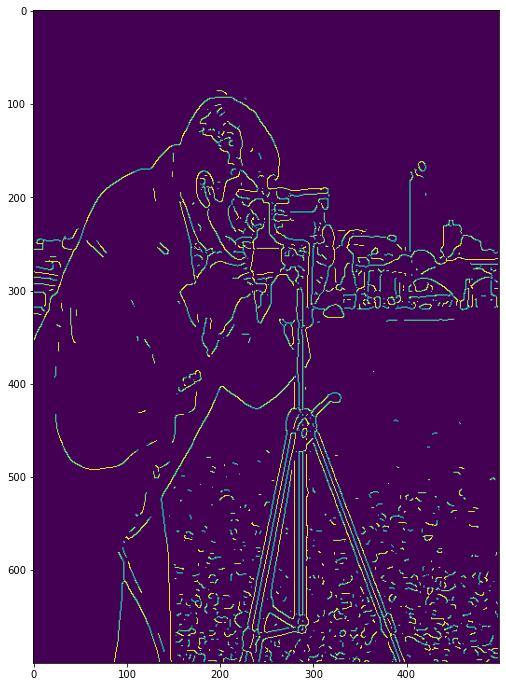

In [10]:
def double_thresholding(g_max, thresh_lo, thresh_hi):

    # TODO
    h, w = g_max.shape
    thresh_img = g_max
    for i in range(h):
        for j in range (w):
            if g_max[i, j]<thresh_lo :
                thresh_img[i, j] = 0
            elif g_max[i, j]>thresh_hi :
                thresh_img[i, j] = 1
            else :
                thresh_img[i, j] = g_max[i, j]
            
    return thresh_img

thresh_img = double_thresholding(g_max, thresh_lo=0.1, thresh_hi=0.2)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(thresh_img)

#### 2.E Edge connectivity

Finally, we decide on edge connectivity as follows: 
* All pixels with strong gradients belong to edges, termed *definite edges*.
* All pixels with weak gradients belong to edges only if they are connected to definite edges. 

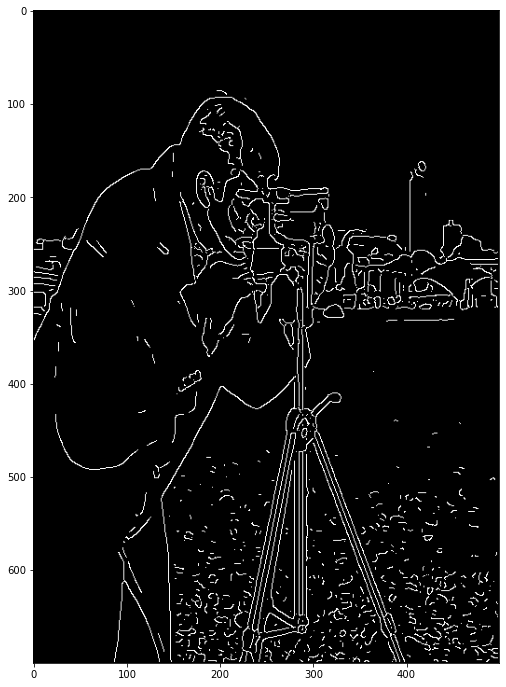

In [11]:
def connectivity(thresh_img):

    # TODO
    h, w = thresh_img.shape
    edge_img = np.zeros_like(thresh_img)
    for i in range(h-1):
        for j in range(w-1):
            if thresh_img[i, j]==1 :
                edge_img[i,j]=1
            elif thresh_img[i, j]==0 :
                edge_img[i,j]=0
            elif (thresh_img[i+1, j]==1) or (thresh_img[i-1, j]==1) or (thresh_img[i, j+1]==1) or (thresh_img[i, j-1]==1) :
                edge_img[i,j]=1

    return edge_img

edge_img = connectivity(thresh_img)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(edge_img, cmap='gray')

Once you complete the above functions, you can run the full pipeline below:

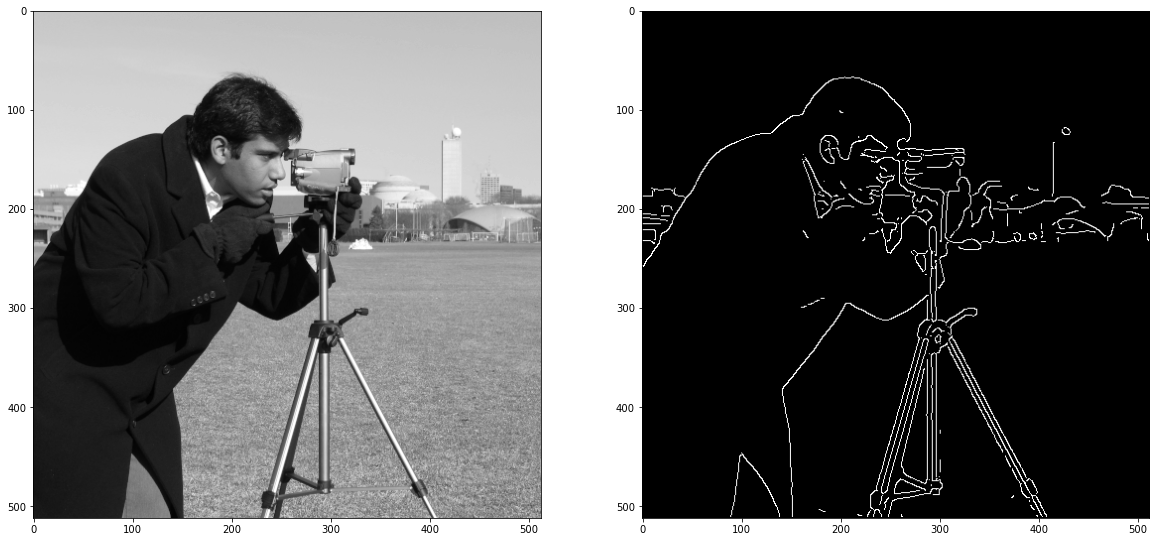

In [12]:
def canny_edge_detector(img, thresh_lo=0.1, thresh_hi=0.2):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img

img = data.camera() / 255.

fig, axes = plt.subplots(figsize=(20, 12), ncols=2)

edges = canny_edge_detector(img)

axes[0].imshow(img, cmap='gray')
axes[1].imshow(edges, cmap='gray')

## 3. Scanning an image

For this problem, you are required to "scan" a shopping receipt in several guided steps. The crucial step consists of a Harris corner detector, which you are to **implement from scratch** and tune to the particularities of the problem. Note that **you will be primarily graded on your Harris implementation**, the scanner application is used to provide context.

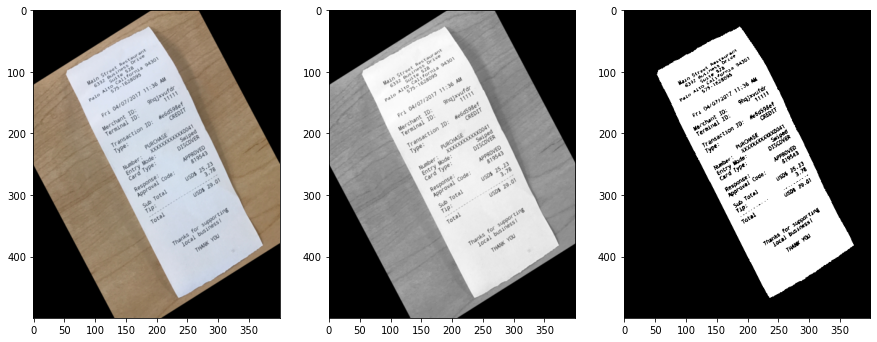

In [16]:
from skimage.io import imread
from skimage.transform import rotate

img_rgb = imread('receipt.png')
img = rgb2gray(img_rgb)

mask = img > 0.7

fig, axes = plt.subplots(figsize=(15, 10), ncols=3)
axes[0].imshow(img_rgb, cmap='gray')
axes[1].imshow(img, cmap='gray')
axes[2].imshow(mask, cmap='gray')

Work on the image mask and apply some morphological filters to remove the text from the receipt. This will make it easier to extract the desired corner features.

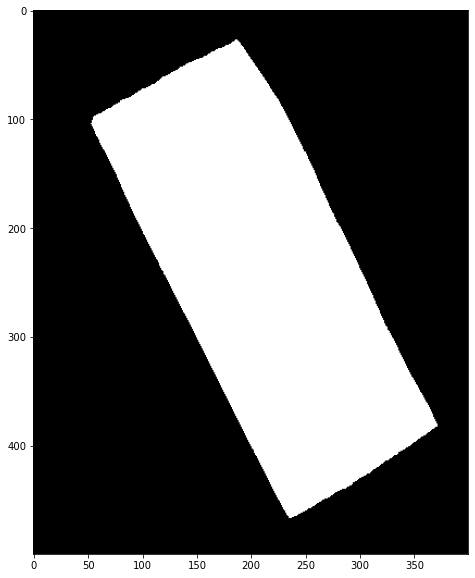

In [17]:
from skimage.morphology import *

img_bg = area_closing(mask, area_threshold=120, connectivity=1, parent=None, tree_traverser=None)

fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img_bg, cmap='gray')

Implement the Harris corner detector *from scratch*. Tune your parameters to extract **the four corner points only**. You should use `skimage.feature.corner_peaks` to extract your corner coordinates. You can tune the function parameters to whatever values necessary to obtain the four corners of the receipt. The corners should be of the format `np.array([[y1, x1], [y2, x2], ..., [yn, xn]])`. Use `pyplot` to verify.

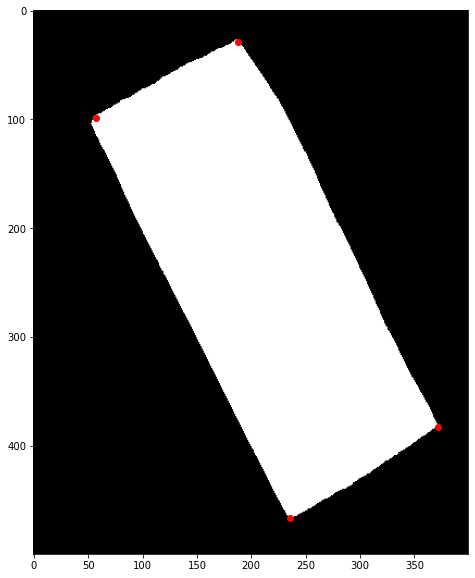

In [18]:
from skimage.feature import corner_peaks
from scipy import signal as sig
from scipy import ndimage as ndi

GX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
GY = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
GAUSS = np.array([[1/16, 2/16, 1/16], [2/16, 4/16, 2/16], [1/16, 2/16, 1/16]])

def harris_corner_detector(img, k):

    #img = gaussian_filter(img, 2)
    h, w = img.shape
    res = np.zeros((h,w))
    corners = []
    
    #compute the gradient
    Ix = sig.convolve2d(img, GX)
    Iy = sig.convolve2d(img, GY)
    
    dIx2 = Ix*Ix
    dIy2 = Iy*Iy
    dIxy = Ix*Iy
        
    Ixx = ndi.gaussian_filter(dIx2, sigma = 2)
    Iyy = ndi.gaussian_filter(dIy2, sigma = 2)
    Ixy = ndi.gaussian_filter(dIxy, sigma = 2)
     
    detH = Ixx*Iyy - Ixy**2
    traceH = Ixx + Iyy
    res = detH - k*traceH**2
        
    corners = corner_peaks(res, min_distance=20, threshold_rel=0, num_peaks = 4)
    
    return corners

corners = harris_corner_detector(img_bg, k = 0.05)

fig, ax = plt.subplots(figsize=(8, 10))

ax.imshow(img_bg, cmap='gray')
ax.scatter(corners[:, 1], corners[:, 0], color='red')

The next step has been written for you. It sorts the corner points, and uses them to compute the geometric transformation to a rectified set of points. **N.B** the requires exactly four corner points.

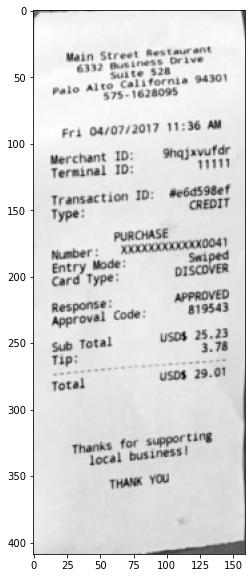

In [19]:
from skimage.transform import estimate_transform, warp


def point_transform(img, corners):
    
    """
    Point transform.
    
    Inputs:
        img              The input image
        corners          The corners to rectify

    Outputs: 
        warped           The transformed image, aligning the input corners
                         to the rectified targets.
    """

    
    # (y, x) -> (x, y)
    corners = np.roll(corners, shift=1, axis=1)

    # sort points (required for transform)
    cs = corners[corners[:, 1].argsort()]
    t = cs[:2]
    tl, tr = t[t[:, 0].argsort()]

    b = cs[2:]
    bl, br = b[b[:, 0].argsort()]

    sorted_corners = np.stack([tl, tr, bl, br])
    
    # calculate dimensions
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    width = int(max(width_1, width_2))

    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    height = int(max(height_1, height_2))

    rectified = np.array([[0, 0], [width - 1, 0], [0, height - 1], [width - 1, height - 1]])

    # compute transformation matrix and warp
    M = estimate_transform('euclidean', sorted_corners, rectified)
    warped = warp(img, M.inverse)[:height, :width]

    return warped

warped = point_transform(img, corners)

fig, ax = plt.subplots(figsize=(8, 10))

ax.imshow(warped, cmap='gray')

Finally, apply a local threshold with `skimage.filters.threshold_local` to remove the shadow and give it that scanned look:

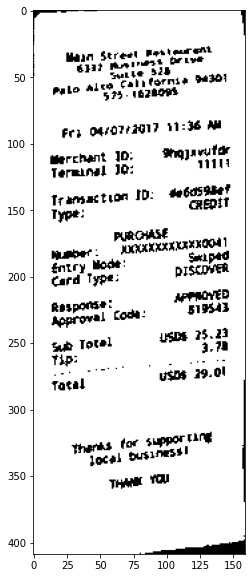

In [48]:
from skimage.filters import threshold_local

scanned = warped > threshold_local(warped, block_size=105, offset=0.1)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(scanned, cmap='gray')